<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Climatologies, anomalies and trends

<br>

### About

This notebook provides you a practical introduction to the topic of analysing climatologies, anomalies and trends.

There are two practical case studies:


* [1 - Calculation of the global mean temperature anomaly](#global_mean)
* [2 - Seasonal variations of the global mean temperature over the Arctic](#arctic)

### Data

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)

<br>

<hr>

### Load libraries

In [2]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='data_preparation'></a>1. Data preparation

The example below will show you how you can use ERA-5 reanalysis data to analyse climatologies and trends of the global near-surface air temperature.

> **Data**: `ERA-5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Jan 1979 to Dec 2020` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

### Load the dataset

The first step is to open the dataset with the function `open_dataset()` of the Python library [xarray](http://xarray.pydata.org/en/stable/). xarray is a Python library that makes the handling of multi-dimensional meteorological and climate data as well as `netCDF` data very efficient. The data file is available under the path: `./data/era5_monthly_t2m.nc`. 

The `open_dataset()` function returns a `xarray.Dataset` object, which can hold one or more `xarray.DataArray` objects, which are aligned on the same dimensions. The loaded `xarray.Dataset` has the following specifications: 
* three dimensions: `latitude`, `longitude` and `time` and
* 1 data variable: `t2m`

In [26]:
file = './data/era5_monthly_t2m.nc'

In [27]:
era5_t2m_ds = xr.open_dataset(file)
era5_t2m_ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-16 13:01:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

Above, you see that the spatial resolution of ERA-5 data is 0.25 degrees for both, latitude and longitude coordinates. What is striking though is that the `longitude` variables are in the range of `[0, 359.75]`. Per default, ECMWF data are on a [0, 360] grid. There are two options to bring the longitude coordinates to a `[-180, 180]` grid. The first option, in case you already have the data downloaded, you can assign values to coordinates with the xarray function `assign_coords()`. The code below shifts your longitude coordinates from `[0, 359.75]` to `[-180, 179.75]`.

The second option is to specify the `area` keyword argument right when you request data with the `CDS API`. The `area` keyword then automatically reprojects the requested data onto a [-180, 180] grid. See an example request with the `area` keyword [here]().

In [28]:
era5_t2m_ds_assigned = era5_t2m_ds.assign_coords(longitude=(((era5_t2m_ds.longitude + 180) % 360) - 180)).sortby('longitude')
era5_t2m_ds_assigned

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 504)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 244.70714 ... 247.45421
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-16 13:01:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

The next step is to load the data variable `t2m` as `xarray.DataArray` object. You can load a data variable from an `xarray.Dataset` by specifying the name of the data variable (`t2m`) in square brackets `[]`. A `xarray.DataArray` object is a labeled, multi-dimensional array, which you can modify and apply operations on. Below, you see additional `attributes` of the data variable, such as `units` and `long_name`.

In [29]:
era5_t2m_da = era5_t2m_ds_assigned['t2m']
era5_t2m_da

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[244.70714, 244.70714, ..., 244.70714, 244.70714],
        [244.41269, 244.41092, ..., 244.41269, 244.41269],
        ...,
        [242.56839, 242.57014, ..., 242.56485, 242.56662],
        [242.92807, 242.92807, ..., 242.92807, 242.92807]],

       [[241.44699, 241.44699, ..., 241.44699, 241.44699],
        [241.12256, 241.1208 , ..., 241.12256, 241.12256],
        ...,
        [233.81058, 233.81587, ..., 233.8053 , 233.8088 ],
        [234.14558, 234.14558, ..., 234.14558, 234.14558]],

       ...,

       [[260.41724, 260.41724, ..., 260.41724, 260.41724],
        [260.4613 , 260.4613 , ..., 260.46484, 260.46307],
        ...,
        [240.75934, 240.76286, ..., 240.75406, 240.75758],
        [241.0679 , 241.0679 , ..., 241.0679 , 241.0679 ]],

       [[252.33298, 252.33298, ..., 252.33298, 252.33298],
        [252.29065, 252.2889 , ..., 252.29242, 252.29065],
        ...,
        [247.13155, 247.1333 , ...

<br>

Above, you see that the ERA-5 temperature data are per default in `Kelvin`, the base unit for temperature in the International System of Units (SI). If you want to convert the values from `Kelvin` to `degrees Celsius`, you have to subtract 273.15.

In [31]:
era5_t2m_da_degc = era5_t2m_da - 273.15
era5_t2m_da_degc

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[-28.442856, -28.442856, ..., -28.442856, -28.442856],
        [-28.737305, -28.739075, ..., -28.737305, -28.737305],
        ...,
        [-30.581604, -30.57985 , ..., -30.585144, -30.583374],
        [-30.221924, -30.221924, ..., -30.221924, -30.221924]],

       [[-31.703003, -31.703003, ..., -31.703003, -31.703003],
        [-32.027435, -32.02919 , ..., -32.027435, -32.027435],
        ...,
        [-39.339417, -39.33412 , ..., -39.344696, -39.341187],
        [-39.00441 , -39.00441 , ..., -39.00441 , -39.00441 ]],

       ...,

       [[-12.732758, -12.732758, ..., -12.732758, -12.732758],
        [-12.68869 , -12.68869 , ..., -12.68515 , -12.68692 ],
        ...,
        [-32.390656, -32.38713 , ..., -32.395935, -32.39241 ],
        [-32.082092, -32.082092, ..., -32.082092, -32.082092]],

       [[-20.817017, -20.817017, ..., -20.817017, -20.817017],
        [-20.859344, -20.8611  , ..., -20.857574, -20.

<br>

Above, you see that when you convert the data values, the data array's `Attributes` are dropped. However, we want to keep the information provided by the `Attributes` and for this reason, we re-assign the attributes from the `era5_t2m_da` object with the function `assign_attrs()`. Since the unit has changed, we assign a new unit measure to the `units` attribute.

In [37]:
era5_t2m_da_degc = era5_t2m_da_degc.assign_attrs(era5_t2m_da.attrs)
era5_t2m_da_degc.attrs['units'] = '° C'
era5_t2m_da_degc

<xarray.DataArray 't2m' (time: 504, latitude: 721, longitude: 1440)>
array([[[-28.442856, -28.442856, ..., -28.442856, -28.442856],
        [-28.737305, -28.739075, ..., -28.737305, -28.737305],
        ...,
        [-30.581604, -30.57985 , ..., -30.585144, -30.583374],
        [-30.221924, -30.221924, ..., -30.221924, -30.221924]],

       [[-31.703003, -31.703003, ..., -31.703003, -31.703003],
        [-32.027435, -32.02919 , ..., -32.027435, -32.027435],
        ...,
        [-39.339417, -39.33412 , ..., -39.344696, -39.341187],
        [-39.00441 , -39.00441 , ..., -39.00441 , -39.00441 ]],

       ...,

       [[-12.732758, -12.732758, ..., -12.732758, -12.732758],
        [-12.68869 , -12.68869 , ..., -12.68515 , -12.68692 ],
        ...,
        [-32.390656, -32.38713 , ..., -32.395935, -32.39241 ],
        [-32.082092, -32.082092, ..., -32.082092, -32.082092]],

       [[-20.817017, -20.817017, ..., -20.817017, -20.817017],
        [-20.859344, -20.8611  , ..., -20.857574, -20.

<br>

Now, let us visualize one time step to get a better idea of the data. xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array.

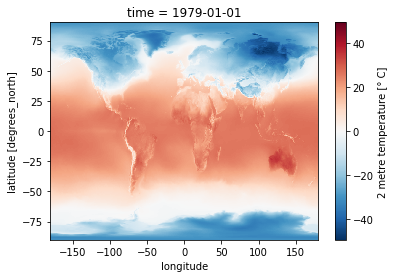

In [38]:
era5_t2m_da_degc[0,:,:].plot()

<br>

An alternative to the built-in xarray plotting functions is to make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). One of Cartopy's key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations. 

The code below defines a visualisation function, that combines matplotlib's `pcolormesh()` function with Cartopy's projection capabilites. The function allows to set the following mandatory and optional keyword arguments (kwargs), which give a great flexibility to customize your visualisation:
* `data_array`: xarray.DataArray
* `longitude`, `latitude`: longitude and latitude coordinates
* `projection`: one of [Cartopy's projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)
* `color_scale`: one of [matplotlib's colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* `unit`: can be taken from the data's attributes
* `long_name`: can be taken from the data's attributes
* `vmin`, `vmax`: minimum and maximum values for color range
* `set_global` (optional): ability to also show a geographic subset
* `lonmin`, `lonmax`, `latmin`, `latmax` (optional): ability to specify a bounding box



> **Note:** we define a function for the visualization code, as we expect to re-use the same code for many data visualisations. See a full list of defined function [here](./functions.ipynb).

In [10]:
def visualize_pcolormesh(data_array, longitude, latitude, projection, color_scale, unit, long_name, vmin, vmax, 
                         set_global=True, lonmin=-180, lonmax=180, latmin=-90, latmax=90):
    """ 
    Visualizes a xarray.DataArray with matplotlib's pcolormesh function.
    
    Parameters:
        data_array(xarray.DataArray): xarray.DataArray holding the data values
        longitude(xarray.DataArray): xarray.DataArray holding the longitude values
        latitude(xarray.DataArray): xarray.DataArray holding the latitude values
        projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
        color_scale(str): string taken from matplotlib's color ramp reference
        unit(str): the unit of the parameter, taken from the NetCDF file if possible
        long_name(str): long name of the parameter, taken from the NetCDF file if possible
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
        set_global(boolean): optional kwarg, default is True
        lonmin,lonmax,latmin,latmax(float): optional kwarg, set geographic extent is set_global kwarg is set to 
                                            False

    """
    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=projection)
   
    img = plt.pcolormesh(longitude, latitude, data_array, 
                        cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax,
                        shading='auto')

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    if (projection==ccrs.PlateCarree()):
        ax.set_extent([lonmin, lonmax, latmin, latmax], projection)
        gl = ax.gridlines(draw_labels=True, linestyle='--')
        gl.top_labels=False
        gl.right_labels=False
        gl.xformatter=LONGITUDE_FORMATTER
        gl.yformatter=LATITUDE_FORMATTER
        gl.xlabel_style={'size':14}
        gl.ylabel_style={'size':14}

    if(set_global):
        ax.set_global()
        ax.gridlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(long_name, fontsize=20, pad=20.0)

    return fig, ax

<br>

The next step is to apply the function `visualize_pcolormesh` to the loaded data. Below, we visualize the first time step (`January 1979`) and use the projection `ccrs.PlateCarree()` to visualize the data. 
Feel free to modify some keywords:
* `color_scale`: we chose `viridis`. Feel free to try out other [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) offered by matplotlib, e.g. `magma`, `inferno`, `RdBu_r`
* `vmin`, `vmax`: with `xarray.DataArray.min()` and `xarray.DataArray.max()` you can retrieve the minimum and maximum values in order to adjust the color range

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fedc005a860>)

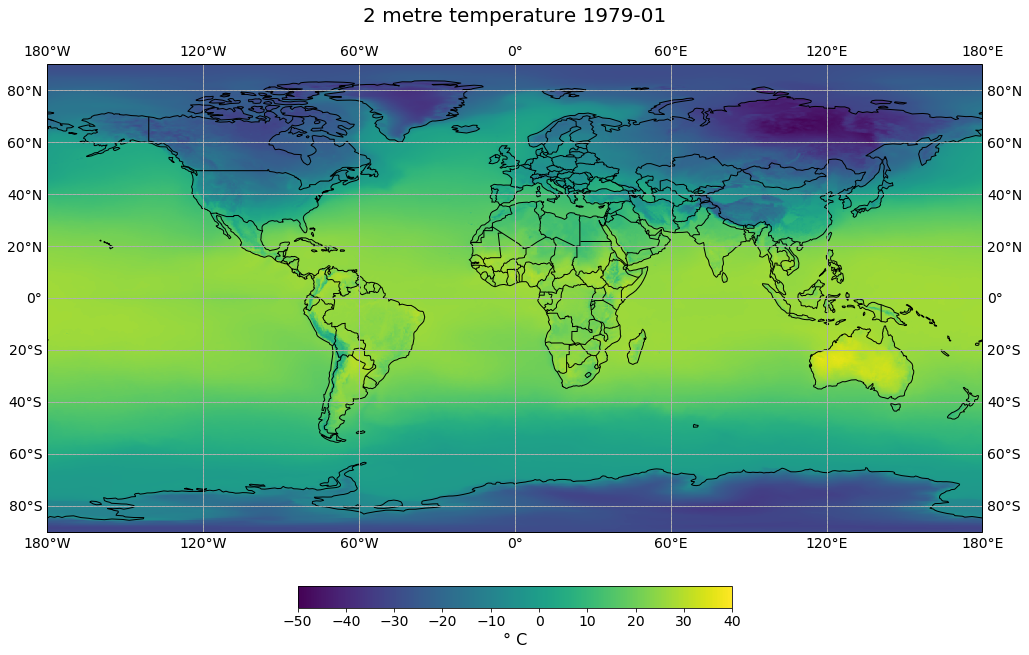

In [51]:
visualize_pcolormesh(data_array = era5_t2m_da_degc[0,:,:],
                    longitude = era5_t2m_da_degc.longitude,
                    latitude = era5_t2m_da_degc.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'viridis',
                    unit = era5_t2m_da_degc.units,
                    long_name = era5_t2m_da_degc.long_name + ' ' + str(era5_t2m_da_degc[0,:,:].time.data)[0:7] + '\n',
                    vmin = -50,
                    vmax = 40)

<br>

Now, the DataArray object `era5_t2m_da_degc` is in a format which allows us to proceed to analyse temperature anomalies and trends.

## <a id='global_mean'></a> 2. Calculation of the annual global mean surface air temperature anomaly

### Standard reference period and climate normals

Human-induced global warming and natural variations from year to year and even from decade to decade shape the Earth's climate. In order to assess an anomaly of a specific month or year, the World Meteorological Organization (WMO) defines `standard reference periods` in order to create `climate normals`. `Climate normals` can be considered as the typical climate for the period the normals are based on.

Until 2020, the most current and widely used standard reference period was the 30-year period 1981-2010. With the start of 2021 and the move into a new decade, the WMO recommends and the Copernicus Climate Change Service will use the period 1991-2020 climate normal period as the main reference period.


First, let us calculate the global near-surface air temperature climate normal for the reference period 1981-2010. For this, we first have to create for each year the average near-surface air temperature. You can use the xarray function `groupby()` to first group the data by year (specify `time.year`) and then to create the average of each year with the function `mean()`. The resulting object contains for each year from 1979 to 2020 the average annual global mean surface air temperature.

<br>

**Note**: the `groupby()` operation dropped again the `Attributes` from the DataArray. 

In [52]:
yearly_mean = era5_t2m_da_degc.groupby('time.year').mean('time')
yearly_mean

<xarray.DataArray 't2m' (year: 42, latitude: 721, longitude: 1440)>
array([[[-15.298064, -15.298064, ..., -15.298064, -15.298064],
        [-15.436477, -15.436917, ..., -15.435741, -15.436181],
        ...,
        [-45.55528 , -45.55292 , ..., -45.558804, -45.557037],
        [-45.233643, -45.233643, ..., -45.233643, -45.233643]],

       [[-14.361809, -14.361809, ..., -14.361809, -14.361809],
        [-14.552819, -14.552966, ..., -14.552382, -14.552528],
        ...,
        [-45.579227, -45.577312, ..., -45.58305 , -45.58113 ],
        [-45.37322 , -45.37322 , ..., -45.37322 , -45.37322 ]],

       ...,

       [[-13.852094, -13.852094, ..., -13.852094, -13.852094],
        [-13.849013, -13.849011, ..., -13.847983, -13.848277],
        ...,
        [-45.306072, -45.304317, ..., -45.309452, -45.307697],
        [-44.965336, -44.965336, ..., -44.965336, -44.965336]],

       [[-12.439185, -12.439185, ..., -12.439185, -12.439185],
        [-12.433015, -12.43419 , ..., -12.431987, -12.4

<br>

From the data array object above, we can then filter the years of the reference period with the function `where()`. Inside the function, you can filter on the data dimensions. In the example below, you want to filter all years after 1980 and before 2011.

In [53]:
era5_t2m_ref = yearly_mean.where((yearly_mean.year > 1980) & (yearly_mean.year < 2011), drop=True)
era5_t2m_ref

<xarray.DataArray 't2m' (year: 30, latitude: 721, longitude: 1440)>
array([[[-13.576743, -13.576743, ..., -13.576743, -13.576743],
        [-13.868111, -13.868259, ..., -13.869287, -13.868698],
        ...,
        [-44.811646, -44.80988 , ..., -44.81503 , -44.813847],
        [-44.518814, -44.518814, ..., -44.518814, -44.518814]],

       [[-13.987714, -13.987714, ..., -13.987714, -13.987714],
        [-14.27879 , -14.278937, ..., -14.278054, -14.278496],
        ...,
        [-44.51132 , -44.509552, ..., -44.51411 , -44.512634],
        [-44.123707, -44.123707, ..., -44.123707, -44.123707]],

       ...,

       [[-12.651946, -12.651946, ..., -12.651946, -12.651946],
        [-12.725266, -12.725558, ..., -12.723503, -12.724677],
        ...,
        [-45.36191 , -45.360443, ..., -45.365147, -45.363678],
        [-44.95579 , -44.95579 , ..., -44.95579 , -44.95579 ]],

       [[-14.483764, -14.483764, ..., -14.483764, -14.483764],
        [-14.449229, -14.44923 , ..., -14.449229, -14.4

<br>

In a last step, we want to create the average near-surface air temperature for the reference period. We can do this by applying the function `mean()` and specify the dimension `year` as the dimension to be averaged. The resulting data array remains with two dimensions, latitude and longitude.

In [54]:
era5_t2m_ref_mean = era5_t2m_ref.mean(dim="year")
era5_t2m_ref_mean

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-14.215117, -14.215117, -14.215117, ..., -14.215117, -14.215117,
        -14.215117],
       [-14.29575 , -14.296027, -14.296268, ..., -14.295077, -14.295232,
        -14.295549],
       [-14.317957, -14.318407, -14.318906, ..., -14.316492, -14.316957,
        -14.31743 ],
       ...,
       [-45.923943, -45.920464, -45.916954, ..., -45.93445 , -45.93093 ,
        -45.92744 ],
       [-45.787704, -45.78594 , -45.784245, ..., -45.792908, -45.791145,
        -45.789494],
       [-45.456154, -45.456154, -45.456154, ..., -45.456154, -45.456154,
        -45.456154]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

<br>

In a next step, let us visualize the average near-surface air temperature for the reference period 1981-2010. As the attributes have dropped again after the `groupby()` operation, we might want to re-assign them with the function `assign_attrs()`. This time though, we can alter the `long_name` attribute and specify the operation conducted on the data. 


In [55]:
era5_t2m_ref_mean = era5_t2m_ref_mean.assign_attrs(era5_t2m_da_degc.attrs)
era5_t2m_ref_mean.attrs['long_name'] = 'Average near-surface air temperature for reference period 1981-2010'
era5_t2m_ref_mean

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-14.215117, -14.215117, -14.215117, ..., -14.215117, -14.215117,
        -14.215117],
       [-14.29575 , -14.296027, -14.296268, ..., -14.295077, -14.295232,
        -14.295549],
       [-14.317957, -14.318407, -14.318906, ..., -14.316492, -14.316957,
        -14.31743 ],
       ...,
       [-45.923943, -45.920464, -45.916954, ..., -45.93445 , -45.93093 ,
        -45.92744 ],
       [-45.787704, -45.78594 , -45.784245, ..., -45.792908, -45.791145,
        -45.789494],
       [-45.456154, -45.456154, -45.456154, ..., -45.456154, -45.456154,
        -45.456154]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    units:      ° C
    long_name:  Average near-surface air temperature for reference period 198...

<br>

Now, we can use the function `visualize_pcolormesh()` to visualize the data array object `era5_t2m_ref_mean`.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fedc004d390>)

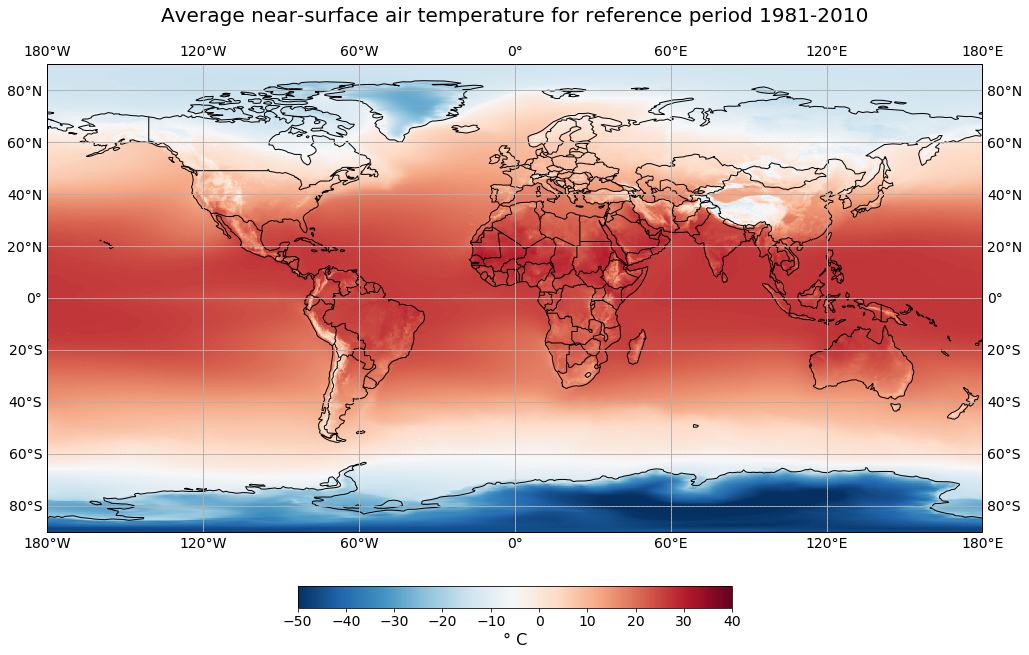

In [56]:
visualize_pcolormesh(data_array = era5_t2m_ref_mean,
                    longitude = era5_t2m_ref_mean.longitude,
                    latitude = era5_t2m_ref_mean.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'RdBu_r',
                    unit = era5_t2m_ref_mean.units,
                    long_name = era5_t2m_ref_mean.long_name + '\n',
                    vmin = -50,
                    vmax = 40)

<br>

### Anomalies

The next step is now to calculate the anomaly of a specific year from the reference value. The term anomaly refers to the deviation of a value from the long-term average. A positive anomaly indicates that the average temperature of this particular year was warmer than the reference value, while a negative anomaly indicates that the average temperature for this year was cooler than the reference value.

Globally, 2016 and 2020 were so far the hottest years on record. Let us calculate the near-surface air temperature anomaly for the year 2016. In a first step, we select the average near-surface temperature values for the year 2016 from the xarray.DataArray object `yearly_mean`. With the xarray function `sel()`, you can select a data array based on labels. The label of interest is `2016`.

In [59]:
era5_t2m_2016 = yearly_mean.sel(year=2016)
era5_t2m_2016

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-11.07256 , -11.07256 , -11.07256 , ..., -11.07256 , -11.07256 ,
        -11.07256 ],
       [-11.12693 , -11.127369, -11.128104, ..., -11.126485, -11.126633,
        -11.127075],
       [-11.153811, -11.1544  , -11.154988, ..., -11.152199, -11.152936,
        -11.15352 ],
       ...,
       [-45.929073, -45.926136, -45.922756, ..., -45.938324, -45.934956,
        -45.932163],
       [-45.872356, -45.871037, -45.869415, ..., -45.87749 , -45.875732,
        -45.873974],
       [-45.58995 , -45.58995 , -45.58995 , ..., -45.58995 , -45.58995 ,
        -45.58995 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    year       int64 2016

<br>

Next, we calculate the near-surface air temperature anomaly of the year 2016 by subtracting the reference near-surface temperature values (data array `era5_t2m_ref_mean`) from the average near-surface air temperature from 2016.

In [61]:
era5_t2m_ref_mean

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[-14.215117, -14.215117, -14.215117, ..., -14.215117, -14.215117,
        -14.215117],
       [-14.29575 , -14.296027, -14.296268, ..., -14.295077, -14.295232,
        -14.295549],
       [-14.317957, -14.318407, -14.318906, ..., -14.316492, -14.316957,
        -14.31743 ],
       ...,
       [-45.923943, -45.920464, -45.916954, ..., -45.93445 , -45.93093 ,
        -45.92744 ],
       [-45.787704, -45.78594 , -45.784245, ..., -45.792908, -45.791145,
        -45.789494],
       [-45.456154, -45.456154, -45.456154, ..., -45.456154, -45.456154,
        -45.456154]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    units:      ° C
    long_name:  Average near-surface air temperature for reference period 198...

In [60]:
era5_t2m_anomaly_2016 = era5_t2m_2016 - era5_t2m_ref_mean
era5_t2m_anomaly_2016

<xarray.DataArray 't2m' (latitude: 721, longitude: 1440)>
array([[ 3.142557,  3.142557,  3.142557, ...,  3.142557,  3.142557,  3.142557],
       [ 3.168819,  3.168658,  3.168164, ...,  3.168592,  3.168599,  3.168474],
       [ 3.164145,  3.164007,  3.163918, ...,  3.164293,  3.164021,  3.163911],
       ...,
       [-0.005131, -0.005672, -0.005802, ..., -0.003876, -0.004025, -0.004723],
       [-0.084652, -0.085098, -0.085171, ..., -0.084583, -0.084587, -0.08448 ],
       [-0.133797, -0.133797, -0.133797, ..., -0.133797, -0.133797, -0.133797]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    year       int64 2016

<br>

Now, let us visualize the global near-surface air temperature anomaly for 2016. This allow us to see directly regions which were warmer or cooler compared to the reference period. Let us use the function `visualize_pcolormesh()` again.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fed43355240>)

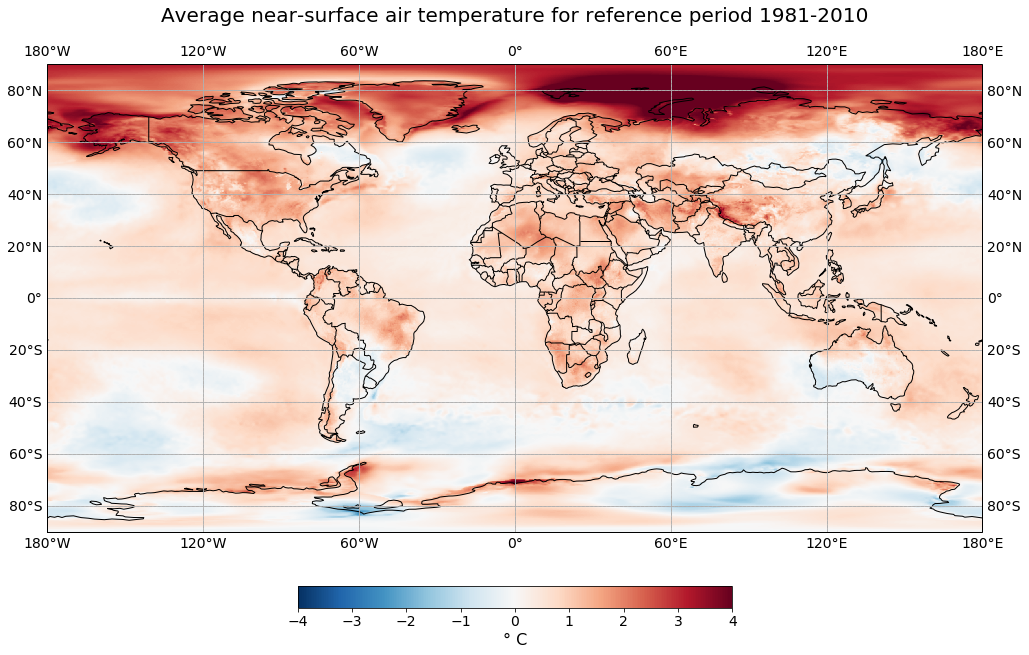

In [63]:
visualize_pcolormesh(data_array = era5_t2m_anomaly_2016,
                    longitude = era5_t2m_anomaly_2016.longitude,
                    latitude = era5_t2m_anomaly_2016.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'RdBu_r',
                    unit = era5_t2m_ref_mean.units,
                    long_name = era5_t2m_ref_mean.long_name + '\n',
                    vmin = -4,
                    vmax = 4)

Notice the strong latitude gradient, and cold regions such as the Tibetan and Andean Plateaus and Greenland.

#### Plot global anomalies

We will now plot a global time series of annual temperature anomalies, defined as deviations in temperature from the reference mean.

Calculate the global mean for the reference period (1981 to 2010), and for the annual data from 1979 to 2019:

In [26]:
# global mean for reference period
ref_global = ref_mean.mean(["longitude", "latitude"])

# global mean for annual data
yearly_mean_global = yearly_mean.mean(["longitude", "latitude"])

We can now derive the anomalies by subtracting the global mean for the reference period from the annual means:

In [27]:
anomalies_global = yearly_mean_global - ref_global

Let's plot the annual global temperature anomalies over time, to see if there are any trends.

In [28]:
# Create a dashed horizontal line to show where the reference temperature lies
mean_line = xr.DataArray(0.0, coords=[('year', np.arange(1981,2010))])

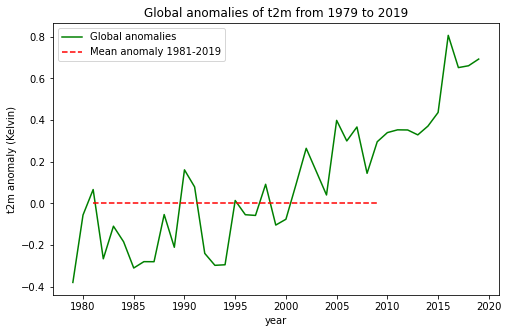

In [29]:
# Create the figure panel 
fig = plt.figure(figsize=(8,5))

# Create the plot within the figure
ax = plt.subplot()

# Set the axes labels and title of plot
ax.set_ylabel('t2m anomaly (Kelvin)')
ax.set_xlabel('year')
ax.set_title('Global anomalies of t2m from 1979 to 2019')

# Plot the data
ax.plot(anomalies_global.year, anomalies_global, color='green', label='Global anomalies')
ax.plot(mean_line.year, mean_line, color='red', linestyle='dashed', label='Mean anomaly 1981-2010')

# Define the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

Notice a clear trend in global temperature!

<br>

## 3. Calculation of the monthly surface air temperature anomaly in Europe

<hr>

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse climatologies and trends in near-surface air temperature. The tutorial comprises the following steps:

1. [Search and download](#search_download) data using the CDS API: We will focus on ERA5 reanalysis data of 2 metre (near-surface) temperature.
2. [Read data](#read_data): Once downloaded, we will read and understand the data, including its variables and coordinates.
3. [View and plot data](#view_plot): We will see how the mean temperature varies globally, and how the Earth is warming by plotting time-series of global anomalies.
4. [Analyse data](#analyse_data) over the Arctic: We will focus on a subset over the Arctic and compare the rate of warming between seasons.

<img src='./img/map_1month_anomaly_Global_ea_2t_202010_title.jpg' align='center' width='100%'></img>

## <a id='read_data'></a>2. Read Data

Now that we have downloaded the data, we can start to play ...

We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! We will read the data from our NetCDF file into an Xarray **"dataset"**

## <a id='analyse_data'></a>4. Analyse data over the Arctic
We will now focus our attention over the Arctic. Here we will repeat the analysis above for this subset area. In addition, we will compare variations in the mean temperature of different seasons throughout the time series.

#### Plot mean Arctic temperature

First we have to create a subset for the Arctic Circle (above lat 66°33'N, or 66.55 in decimal degrees)

In [30]:
arctic = da.where(da.latitude >= 66.55, drop=True)

Calculate mean 2 metre temperature in period 1979 to 2019:

In [31]:
arctic_mean_1979_to_2019 = arctic.mean(dim="time")

Now let's plot this data in a map projection that facilitates visualisation of the Arctic:

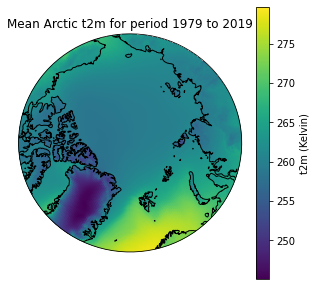

In [32]:
# create the figure panel 
fig = plt.figure(figsize=(5,5))
# create the map using the cartopy Orthographic projection, selecting the North Pole
ax = plt.subplot(1,1,1, projection=ccrs.Orthographic(central_latitude=90.0))
# add coastlines
ax.coastlines()
# compute a circle in axes coordinates, which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# set boundary
ax.set_extent([-180,180, 66.55,90], crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
# provide a title
ax.set_title('Mean Arctic t2m for period 1979 to 2019')
# plot t2m
pp = plt.pcolormesh(arctic_mean_1979_to_2019.longitude, arctic_mean_1979_to_2019.latitude,
                    arctic_mean_1979_to_2019, cmap='viridis', transform=ccrs.PlateCarree())
# add colourbar
cbar = plt.colorbar(pp)
cbar.set_label(label='t2m (Kelvin)')

#### Plot monthly time series
Let's plot the monthly time series to see if we can identify any trends.

In [33]:
arctic_mean = arctic.mean(["longitude", "latitude"])

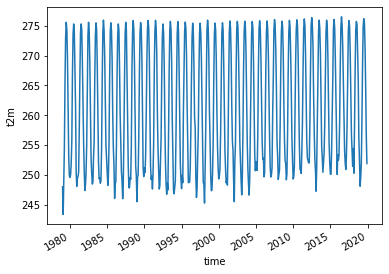

In [34]:
arctic_mean.plot()

Can you identify any global warming? The strong seasonal variations are evident throughout each year, but it is difficult to see any clear long-term trends.

#### Plot yearly time series
Now let's plot a time series of yearly averages. By removing the seasonal variations, perhaps we can identify some long-term trends.

In [35]:
arctic_yearly_mean = arctic_mean.groupby('time.year').mean('time')

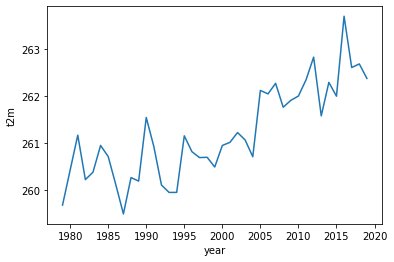

In [36]:
arctic_yearly_mean.plot()

Now we can clearly see a positive trend in warming throughout the time-series!

#### Plot seasonal time series

It may be interesting to compare trends in the mean temperature of different seasons throughout the time series. Do they vary? Are some seasons more constant over time, while others fluctuate?

In [37]:
# Create rolling average of three months
arctic_roll = arctic_mean.rolling(time=3, center=True).mean()

In [38]:
MAM = arctic_roll[3:-8:12] # MAM = March, April, May (Spring)
JJA = arctic_roll[6:-5:12] # JJA = June, July, August (Summer)
SON = arctic_roll[9:-2:12] # SON = September, October, November (Autumn)
DJF = arctic_roll[12:-11:12] # DJF = December, January, February (Winter)

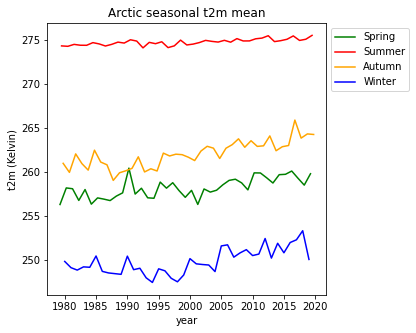

In [39]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.set_ylabel('t2m (Kelvin)')
ax.set_xlabel('year')
ax.plot(MAM.time, MAM, color='green', label='Spring')
ax.plot(JJA.time, JJA, color='red', label='Summer')
ax.plot(SON.time, SON, color='orange', label='Autumn')
ax.plot(DJF.time, DJF, color='blue', label='Winter')
ax.set_title('Arctic seasonal t2m mean')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')

Note the difference in variability of seasonal mean t2m throughout the time series: mean summer temperatures are more constant than in other seasons.